## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|x^2+y^2 < 1\}$

The exact solution to this problem is $$u = \frac{1}{4}(x^2+y^2-1).$$

In [58]:
% matplotlib inline
import torch 
import torch.nn.functional as F
#learning rate decay
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
        '''
        torch.nn.init.xavier_uniform_(self.linear1.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear2.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear3.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear4.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear5.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear6.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear7.weight, gain=torch.nn.init.calculate_gain('relu'))
        '''
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [2]:
def draw_graph(mod):
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [ ]:
def cal_loss(mod):
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
            #?????????
            if re[0] ** 2 + re[1] ** 2 < 1 : 
                mmm += abs(z[i, j])
                t += 1
    return mmm / t

In [57]:
#相对误差
#余冰的例子里面是
#print(np.linalg.norm(np.reshape(u_solve[:,0]-pu,[-1]),ord=2)/np.linalg.norm(np.reshape(pu,[-1]),ord=2))
def relative_err(mod):
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    w = np.zeros((xl, yl))
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)
            if re[0] ** 2 + re[1] ** 2 < 1 :
                z[i, j] = mod(re.float()).item() + U_groundtruth(re)
                w[i, j] = U_groundtruth(re)
                t += 1
    z = z ** 2
    w = w ** 2
    return np.sum(z) / np.sum(w)

In [4]:
#U_groundtruth = 1/4*(x^2+y^2)-1/4
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    #re = 0
    re = (t[0] ** 2 + t[1] ** 2 - 1).item() / 4
    return re

In [5]:
def validate(mod):
    draw_graph(mod)
    print(cal_loss(mod))

In [15]:
m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error
gamma = 10

In [42]:
"""
Train with the grid
从初始化模型开始训练
"""

model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = MultiStepLR(optimizer, milestones=[300, 400], gamma=0.1)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
points = np.arange(-1, 1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()
                
for k in range(iterations):
    n1 = 0
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                n1 += 1
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (model(x_input_1) + model(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (model(x_input_2) + model(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y #+ gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                #loss = gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
    loss /= n1
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if gamma < 500:
        gamma = gamma * 1.01
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss(model))
    if cal_loss(model) < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    
    #scheduler.step()
    optimizer.step()
    

0  epoch, loss:  0.003757581
0  epoch, regularization loss:  0.0014568424
0  loss to real solution:  0.12585706354720796
1  epoch, loss:  0.0017227847
1  epoch, regularization loss:  0.0049991105
1  loss to real solution:  0.12494390999197574
2  epoch, loss:  -0.006674614
2  epoch, regularization loss:  0.010949647
2  loss to real solution:  0.12307167222837155
3  epoch, loss:  -0.02460782
3  epoch, regularization loss:  0.020303011
3  loss to real solution:  0.12117159876601107
4  epoch, loss:  -0.05633974
4  epoch, regularization loss:  0.034012053
4  loss to real solution:  0.11934473653698269
5  epoch, loss:  -0.10548175
5  epoch, regularization loss:  0.053524155
5  loss to real solution:  0.12056768686058446
6  epoch, loss:  -0.15654023
6  epoch, regularization loss:  0.07246395
6  loss to real solution:  0.1259098148690926
7  epoch, loss:  -0.22613847
7  epoch, regularization loss:  0.09942548
7  loss to real solution:  0.14328349177668728
8  epoch, loss:  -0.30700633
8  epoch, 

68  epoch, loss:  -0.31303304
68  epoch, regularization loss:  0.12824012
68  loss to real solution:  0.24474276994777264
69  epoch, loss:  -0.3133995
69  epoch, regularization loss:  0.12943059
69  loss to real solution:  0.24598872680372746
70  epoch, loss:  -0.31168887
70  epoch, regularization loss:  0.12944536
70  loss to real solution:  0.24600985631490435
71  epoch, loss:  -0.30720967
71  epoch, regularization loss:  0.12664717
71  loss to real solution:  0.24300328696847337
72  epoch, loss:  -0.30309236
72  epoch, regularization loss:  0.124337934
72  loss to real solution:  0.2402248733258323
73  epoch, loss:  -0.29955977
73  epoch, regularization loss:  0.122458495
73  loss to real solution:  0.23763043790001578
74  epoch, loss:  -0.2968656
74  epoch, regularization loss:  0.120770946
74  loss to real solution:  0.23512396680772105
75  epoch, loss:  -0.2950242
75  epoch, regularization loss:  0.119422145
75  loss to real solution:  0.23281713088417352
76  epoch, loss:  -0.293

135  epoch, loss:  -0.18511675
135  epoch, regularization loss:  0.068070784
135  loss to real solution:  0.10102990307608603
136  epoch, loss:  -0.16735941
136  epoch, regularization loss:  0.05208835
136  loss to real solution:  0.08307033642695265
137  epoch, loss:  -0.18566303
137  epoch, regularization loss:  0.06912157
137  loss to real solution:  0.10043656193175118
138  epoch, loss:  -0.19797675
138  epoch, regularization loss:  0.08361306
138  loss to real solution:  0.11340510102138643
139  epoch, loss:  -0.17639354
139  epoch, regularization loss:  0.061338186
139  loss to real solution:  0.0933985694054622
140  epoch, loss:  -0.16324563
140  epoch, regularization loss:  0.048479207
140  loss to real solution:  0.08109942940653711
141  epoch, loss:  -0.18086724
141  epoch, regularization loss:  0.06564093
141  loss to real solution:  0.10021935331093156
142  epoch, loss:  -0.20779179
142  epoch, regularization loss:  0.096356556
142  loss to real solution:  0.125098309712394

KeyboardInterrupt: 

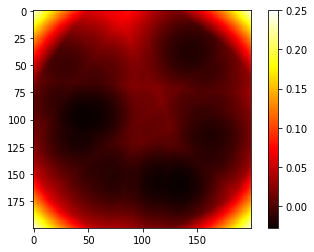

0.012661244662244994


In [42]:
validate(the_model)

In [56]:
relative_err(the_model)

0.013054753003282139

In [45]:
#only save the parameters
PATH = 'test_parameters.pkl'
torch.save(the_model.state_dict(), PATH)

In [55]:
m = 10
PATH = 'test_parameters.pkl'
#从文件读取the_model
the_model = DeepRitzNet(m)
the_model.load_state_dict(torch.load(PATH))

In [49]:
#训练the_model
train(the_model, initial_lr=0.0001*learning_rate)

0  epoch, loss:  -0.088172175
0  epoch, regularization loss:  0.0012239327
0  loss to real solution:  0.013472990111906032
1  epoch, loss:  -0.0882291
1  epoch, regularization loss:  0.001237815
1  loss to real solution:  0.013481815671997424
2  epoch, loss:  -0.08824132
2  epoch, regularization loss:  0.0012518794
2  loss to real solution:  0.01349083595337207
3  epoch, loss:  -0.08827846
3  epoch, regularization loss:  0.0012661172
3  loss to real solution:  0.013499944779267251
4  epoch, loss:  -0.088293396
4  epoch, regularization loss:  0.0012805214
4  loss to real solution:  0.01350929377929956
5  epoch, loss:  -0.0883347
5  epoch, regularization loss:  0.0012950946
5  loss to real solution:  0.01351871069029595
6  epoch, loss:  -0.08835273
6  epoch, regularization loss:  0.001309836
6  loss to real solution:  0.013528317845519318
7  epoch, loss:  -0.08838569
7  epoch, regularization loss:  0.0013247484
7  loss to real solution:  0.013538012560157518
8  epoch, loss:  -0.08839417


66  epoch, loss:  -0.089841425
66  epoch, regularization loss:  0.002561862
66  loss to real solution:  0.01415318651597981
67  epoch, loss:  -0.089886144
67  epoch, regularization loss:  0.0025904805
67  loss to real solution:  0.014164173846459446
68  epoch, loss:  -0.08987862
68  epoch, regularization loss:  0.0026194595
68  loss to real solution:  0.014175319675463935
69  epoch, loss:  -0.08990314
69  epoch, regularization loss:  0.0026487522
69  loss to real solution:  0.014186431006603283
70  epoch, loss:  -0.08993975
70  epoch, regularization loss:  0.0026783654
70  loss to real solution:  0.014197498832101588
71  epoch, loss:  -0.08995296
71  epoch, regularization loss:  0.0027083005
71  loss to real solution:  0.014208538292688552
72  epoch, loss:  -0.089969486
72  epoch, regularization loss:  0.0027385638
72  loss to real solution:  0.014219536739146959
73  epoch, loss:  -0.0900147
73  epoch, regularization loss:  0.0027691573
73  loss to real solution:  0.014230502604288283


131  epoch, loss:  -0.091312595
131  epoch, regularization loss:  0.0052537504
131  loss to real solution:  0.014887844615427222
132  epoch, loss:  -0.09134358
132  epoch, regularization loss:  0.0053117494
132  loss to real solution:  0.014899311897455665
133  epoch, loss:  -0.09136387
133  epoch, regularization loss:  0.0053701857
133  loss to real solution:  0.014910336449215241
134  epoch, loss:  -0.09137352
134  epoch, regularization loss:  0.005429092
134  loss to real solution:  0.01492106950168055
135  epoch, loss:  -0.091394566
135  epoch, regularization loss:  0.00548852
135  loss to real solution:  0.014931525421295876
136  epoch, loss:  -0.09141934
136  epoch, regularization loss:  0.0055485237
136  loss to real solution:  0.014941959578507944
137  epoch, loss:  -0.09144768
137  epoch, regularization loss:  0.005609212
137  loss to real solution:  0.014952502557319055
138  epoch, loss:  -0.09146719
138  epoch, regularization loss:  0.0056705847
138  loss to real solution:  

196  epoch, loss:  -0.09253243
196  epoch, regularization loss:  0.010611118
196  loss to real solution:  0.015575619776915866
197  epoch, loss:  -0.092521876
197  epoch, regularization loss:  0.010724984
197  loss to real solution:  0.015585255701442214
198  epoch, loss:  -0.09252956
198  epoch, regularization loss:  0.010840006
198  loss to real solution:  0.015594809406056639
199  epoch, loss:  -0.09257665
199  epoch, regularization loss:  0.010956205
199  loss to real solution:  0.015604286257093716
200  epoch, loss:  -0.09257309
200  epoch, regularization loss:  0.011073591
200  loss to real solution:  0.01561369598103487
201  epoch, loss:  -0.09259177
201  epoch, regularization loss:  0.0111921625
201  loss to real solution:  0.015623017160455489
202  epoch, loss:  -0.09259643
202  epoch, regularization loss:  0.011311888
202  loss to real solution:  0.0156321842494118
203  epoch, loss:  -0.09259872
203  epoch, regularization loss:  0.011432793
203  loss to real solution:  0.0156

261  epoch, loss:  -0.093206234
261  epoch, regularization loss:  0.020884184
261  loss to real solution:  0.01599677199144452
262  epoch, loss:  -0.093190156
262  epoch, regularization loss:  0.021095648
262  loss to real solution:  0.01599878882288546


KeyboardInterrupt: 

In [20]:
# Calculate time for grid method
def train(mod, initial_lr=learning_rate, milestones=[400], gamma=0.1, iterations=iterations, mm=1):
    optimizer = torch.optim.Adam(mod.parameters(), lr=initial_lr)
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    mm = 1
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()

    #start = time.time()
    for k in range(iterations):
        n1 = 0
        loss = torch.zeros(1)
        for i in range(xl):
            for j in range(yl):        
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]
                if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                    n1 += 1
                    x_input = torch.tensor(x_input).float()
                    y = mod(x_input)

                    x1 = torch.zeros(m)
                    x2 = torch.zeros(m)
                    x1[0] = 0.0001
                    x2[1] = 0.0001
                    x_input_1 = x_input.float() + x1
                    x_input_2 = x_input.float() + x2
                    x_input_3 = x_input.float() - x1
                    x_input_4 = x_input.float() - x2
                    x_input_grad_1 = (mod(x_input_1) - y) / 0.0001
                    x_input_grad_2 = (mod(x_input_2) - y) / 0.0001
                    x_input_2_grad_x = (mod(x_input_1) + the_model(x_input_3) - 2 * y) / 0.0001**2
                    x_input_2_grad_y = (mod(x_input_2) + the_model(x_input_4) - 2 * y) / 0.0001**2

                    loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y #+ gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                    #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                    #loss = gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
        loss /= n1

        regularization = torch.zeros(1)
        for t in range(n2):
            theta = t / n2 * (2 * pi)
            x_input = np.zeros(m)
            x_input[0] = cos(theta)
            x_input[1] = sin(theta)
            x_input = torch.tensor(x_input).float()
            y = mod(x_input)
            regularization += y**2 
        regularization *= mm / n2
        if gamma < 500:
            gamma = gamma * 1.01
        if mm < 500:
            mm = mm * 1.01

        #print loss
        print(k, " epoch, loss: ", loss.data[0].numpy())
        print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
        print(k, " loss to real solution: ", cal_loss(mod))
        if cal_loss(the_model) < 0.0001:
            break

        loss += regularization

        #and step the optimizer
        optimizer.zero_grad()
        loss.backward()

        scheduler.step()
        optimizer.step()
    #stop = time.time()
    #print(stop - start)